In [31]:
import math
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from torch import optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

In [32]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# class SquarePad:
#     def __call__(self, image):
#         max_wh = max(image.size)
#         p_left, p_top = [(max_wh - s) // 2 for s in image.size]
#         p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
#         padding = (p_left, p_top, p_right, p_bottom)
#         return F.pad(image, padding, 0, 'constant')

target_image_size = (32, 32)
transformed=transforms.Compose([
#     SquarePad(),
    transforms.Resize(target_image_size),
    transforms.ToTensor(),
#     transforms.RandomInvert(p=0.5),
#     transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.SVHN),
#     transforms.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 2.5)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.7, hue=0.5),
#     transforms.RandomAdjustSharpness(sharpness_factor=0.1, p=0.5),
#     transforms.RandomAutocontrast(p=0.5),
#     transforms.RandomResizedCrop(size=(32, 32), scale=(0.7, 1.0)),
])

In [35]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transformed, 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transformed
)

In [36]:
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
torch.Size([60000, 28, 28])
torch.Size([60000])


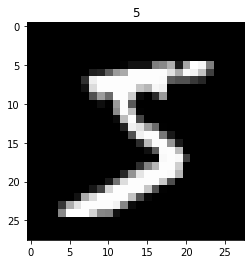

In [37]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

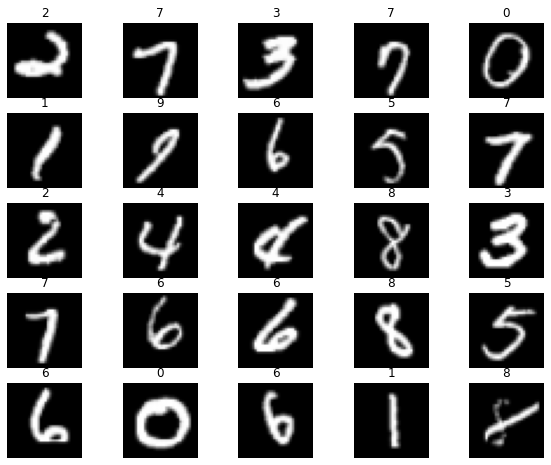

In [38]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [39]:
symbols = ['+', '-', '*', '/']
D = {'+': [1, 0, 0, 0], '-': [0, 1, 0, 0], '*': [0, 0, 1, 0], '/': [0, 0, 0, 1]}

In [40]:
L = []
for i in range(10):
    for j in range(1,10):
        som = i+j
        sub = i-j
        div = round(i/j, 2)
        mult = i*j
        if som not in L:
            L.append(som)
        if sub not in L:
            L.append(sub)
        if mult not in L:
            L.append(mult)
        if div not in L:
            L.append(div)
            
labels_dict = {value: key for (key, value) in enumerate(sorted(L))}
labels_dict[-1000] = len(labels_dict)

inv_labels_dict = {v: k for k, v in labels_dict.items()}
print(labels_dict)
print('\n', len(labels_dict))

{-9: 0, -8: 1, -7: 2, -6: 3, -5: 4, -4: 5, -3: 6, -2: 7, -1: 8, 0: 9, 0.11: 10, 0.12: 11, 0.14: 12, 0.17: 13, 0.2: 14, 0.22: 15, 0.25: 16, 0.29: 17, 0.33: 18, 0.38: 19, 0.4: 20, 0.43: 21, 0.44: 22, 0.5: 23, 0.56: 24, 0.57: 25, 0.6: 26, 0.62: 27, 0.67: 28, 0.71: 29, 0.75: 30, 0.78: 31, 0.8: 32, 0.83: 33, 0.86: 34, 0.88: 35, 0.89: 36, 1: 37, 1.12: 38, 1.14: 39, 1.17: 40, 1.2: 41, 1.25: 42, 1.29: 43, 1.33: 44, 1.4: 45, 1.5: 46, 1.6: 47, 1.67: 48, 1.75: 49, 1.8: 50, 2: 51, 2.25: 52, 2.33: 53, 2.5: 54, 2.67: 55, 3: 56, 3.5: 57, 4: 58, 4.5: 59, 5: 60, 6: 61, 7: 62, 8: 63, 9: 64, 10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 20: 74, 21: 75, 24: 76, 25: 77, 27: 78, 28: 79, 30: 80, 32: 81, 35: 82, 36: 83, 40: 84, 42: 85, 45: 86, 48: 87, 49: 88, 54: 89, 56: 90, 63: 91, 64: 92, 72: 93, 81: 94, -1000: 95}

 96


In [41]:
def calculate_tensor_operation(X, y, op, batch_size=100):
    ''' Concatenate tensors channelwise
    '''
    T = torch.empty(size=(batch_size, 3, 32, 32))
    L = torch.empty(size=(batch_size,))
    for i in range(batch_size):
        rand1, rand2 = random.sample(range(0, batch_size), 2)

        T1, L1 = X[rand1], y[rand1]
        T2, L2 = X[rand2], y[rand2]
        
        v = D[op]
        if op == '+':
            res = L1 + L2
        elif op == '-':
            res = L1 - L2
        elif op == '*':
            res = L1 * L2
        else:
            res = L1 / L2
            if L2 == 0:
                res = torch.tensor(-1000)
                
        item = round(res.item(), 2)
        value = labels_dict[item]
        V = torch.tensor([32*[int(32/4)*v]])
        t = torch.cat((T1, T2, V), 0)
        
        T[i] = t
        L[i] = value
        
    L = L.type(torch.LongTensor)
    return T, L

In [42]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb1738b9278>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fb1738b9400>}

In [43]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
        
#         self.conv_block = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(inplace=True),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2) 
#         )
        
#         self.linear_block = nn.Sequential(
#             nn.Dropout(p=0.3),
#             nn.Linear(128*8*8, 128),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(64, 96)
#         )
        
#     def forward(self, x):
#         x = self.conv_block(x)
#         x = x.view(x.size(0), -1)
#         output = self.linear_block(x)
        
#         return output, x

In [44]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
#             nn.BatchNorm2d(16),
            nn.LeakyReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 1), 
#             nn.BatchNorm2d(32),
            nn.LeakyReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 4, 1, 1),
#             nn.BatchNorm2d(64),
            nn.LeakyReLU(),                      
            nn.MaxPool2d(1),                
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 2),
#             nn.BatchNorm2d(128),
            nn.LeakyReLU(),                      
            nn.MaxPool2d(1),                
        )
        self.dropout = nn.Dropout(0.3)
        self.num_classes = len(labels_dict)
        self.dense_units = 224
        self.linear = nn.Linear(128 * 8 * 8, self.dense_units)
        self.last = nn.Linear(self.dense_units, self.num_classes)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1) # flatten the output of conv2 to (batch_size, n_filters * height * width)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.dropout(x)
        output = self.last(x)
        return output, x    # return x for visualization

In [45]:
cnn = CNN()
print(cnn)

cnn.load_state_dict(torch.load('input/model_20epochs.pth'))

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.05)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=8192, out_feature

In [30]:
num_epochs = 12
def train(num_epochs, cnn, sched, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            X = Variable(images)   # batch x
            y = Variable(labels)   # batch y
            
            for op in symbols:
                
                b_x, b_y = calculate_tensor_operation(X, y, op)
                
                output = cnn(b_x)[0]
                loss = loss_func(output, b_y)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step()                
        
                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                    pass
        
        sched.step()
        pass
    
    pass
train(num_epochs, cnn, scheduler, loaders)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 28 but got size 32 for tensor number 2 in the list.

In [46]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            op = random.choice(symbols)
            images, labels = calculate_tensor_operation(images, labels, op)
            test_output, last_layer = cnn(images)            
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    return accuracy
test()

Test Accuracy of the model on the 10000 test images: 0.92


0.92

In [47]:
results = []
for i in range(5):
    results.append(test())
print(sum(results)/len(results))

Test Accuracy of the model on the 10000 test images: 0.94
Test Accuracy of the model on the 10000 test images: 0.95
Test Accuracy of the model on the 10000 test images: 0.93
Test Accuracy of the model on the 10000 test images: 0.91
Test Accuracy of the model on the 10000 test images: 0.97
0.9400000000000001


In [ ]:
# sample = next(iter(loaders['test']))
# imgs, lbls = sample

In [ ]:
# actual_number = lbls[:10].numpy()
# actual_number

In [ ]:
# test_output, last_layer = cnn(imgs[:10])
# pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
# print(f'Prediction number: {pred_y}')
# print(f'Actual number: {actual_number}')

### Abrindo novas imagens

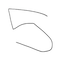

In [49]:
# from PIL import Image

a = Image.open("resources/digit_a.png")
# a = a.resize((32, 32))
b = Image.open("resources/digit_b.png")
# b = b.resize((32, 32))

b

In [50]:
img_to_tensor = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.Grayscale(), 
    transforms.Lambda(lambda x: torchvision.transforms.functional.invert(x)),
    transforms.ToTensor(),
])

a = img_to_tensor(a)
b = img_to_tensor(b)

In [51]:
# convert_tensor = transforms.ToTensor()

# # Image A
# a = ImageOps.grayscale(a)
# a = convert_tensor(a)

# # Image B
# b = ImageOps.grayscale(b)
# b = convert_tensor(b)

In [52]:
def stack_tensors(imgA, imgB, op):
    ''' Stack two 3d images into a 4d tensor
    '''
    T = torch.stack((imgA, imgB))
        
    v = D[op]
    V = torch.tensor([1*[32*[8*v]]])
    
    T = torch.cat((T, V), 0) 
    T = T.permute(1, 0, 2, 3)
    
    return T

In [53]:
def predict_operation(imgA, imgB, operator):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        T = stack_tensors(imgA, imgB, operator)
        test_output, last_layer = cnn(T)            
        pred_y = torch.max(test_output, 1)[1].data.squeeze().item()
        return inv_labels_dict[pred_y]

In [67]:
predict_operation(b, a, '*')

1

In [ ]:
# op = '+'
# for images, labels in loaders['test']:
#     images, labels = calculate_tensor_operation(images, labels, op)
#     break

In [ ]:
for images, labels in loaders['test']:
    img1 = images[6]
    print(labels[6])
    img2 = images[7]
    print(labels[7])
    break

In [ ]:
predict_operation(img1, img2, '*')